# Tutorial 1: CSD-based EWS in the Ricker model

The objectives of this tutorial are as follows:
- Simulate a single stochastic trajectory of the Ricker model going through a Fold bifurcation
- Show how to use the package *ewstools* to compute early warning signals
- Visualise the output

Run time < 1 min


## Import relevant libraries

In [1]:
# We will require the following standard Python packages for this analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ewstools

## Run a simulation of the Ricker model

Let's simulate a single trajectory of the Ricker model going through a Fold bifurcation. We will use this data to demonstrate the process of computing EWS.

**Set simulation parameters**

In [50]:
dt = 1 # time-step (using 1 since discrete-time system)
t0 = 0 # start time
tmax = 2000 # end time
tburn = 100 # burn-in period preceding start-time
seed = 0 # random number generation seed (set for reproducibility)

**Define model**

We use the Ricker model with a Holling Type II harvesting term and additive white noise. It is given by
$$ N_{t+1} = N_t e^{(r(1-N_t/K) + \sigma\epsilon_t} ) - F\frac{N_t^2}{N_t^2 + h^2}$$
where $N_t$ is the population size at time $t$, $r$ is the intrinsic growth rate, $K$ is the carrying capacity, $F$ is the maximum rate of harvesting, $h$ is the half saturation constant of the harvesting term, $\sigma$ is the noise amplitude, and $\epsilon_t$ is a normal random variable with zero mean and unit variance.

In [51]:
# Define the model
def de_fun(x,r,k,f,h,xi):
    return x*np.exp(r*(1-x/k)+xi) - f*x**2/(x**2+h**2)

**Set model parmaeters**

In [52]:
r = 0.75 # growth rate
k = 10 # carrying capacity
h = 0.75 # half-saturation constant of harvesting function
bl = 0 # bifurcation parameter (harvesting) low
bh = 2.7 # bifurcation parameter (harvesting) high
bcrit = 2.364 # bifurcation point (computed using XPPAUT)
sigma = 0.02 # noise intensity
x0 = 0.8 # initial condition

**Initialisation**

In [53]:
# Initialise arrays for time and state values
t = np.arange(t0,tmax,dt)
x = np.zeros(len(t))

# Bifurcation parameter values (increasing linearly in time)
b = pd.Series(np.linspace(bl,bh,len(t)),index=t) # bifurcation parameter values over time (linear increase)

# Compute time at which bifurcation is crossed
tcrit = b[b > bcrit].index[1]

# Array of noise values (normal random variables with variance sigma^2 dt)
dW_burn = np.random.normal(loc=0, scale=sigma*np.sqrt(dt), size = int(tburn/dt)) # burn-in period
dW = np.random.normal(loc=0, scale=sigma*np.sqrt(dt), size = len(t)) # monitored period

**Run simulation**

In [54]:
# Run burn-in period starting from intiial condition x0
for i in range(int(tburn/dt)):
    x0 = de_fun(x0,r,k,bl,h,dW_burn[i])

# State value post burn-in period. Set as starting value.
x[0]=x0

# Run simulation using recursion
for i in range(len(t)-1):
    x[i+1] = de_fun(x[i],r,k,b.iloc[i], h,dW[i])
    # Make sure that state variable stays >= 0
    if x[i+1] < 0:
        x[i+1] = 0
        
# Store data as a pandas series
series = pd.Series(data=x, index=t, name='x')
series.index.name = 'time'

We now have a DataFrame df_traj, contianing our simulation, indexed by time. We can plot it directly from pandas with the following command:

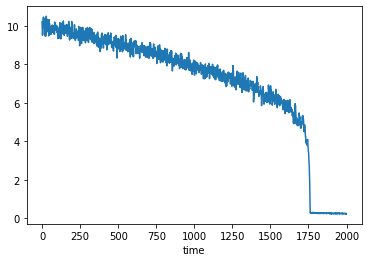

In [55]:
series.plot();

## Compute EWS

*ewstools* can compute the following CSD-based EWS:

| EWS  | Function | Notes |
| ------------- | ------------- | -------------- |
| Variance  | compute_var( )  | Second moment of the data. Increases with critical slowing down. |
| Standard deviation | compute_sd( )  | Root of the variance. Increases with critical slowing down. |
| Coefficient of variation | compute_cv( ) | Ratio of standard deviation to the mean. Useful when mean of system varies over time. |
| Skewness | compute_skew( )  | Third moment (standardised) of the data. Increases in magnitude (positive or negative) prior to fold bifurcations. |
| Kurtosis | compute_kurt( )  | Fourth standardised moment of the data |
| Lag-tau autocorrelation | compute_ac(lag=tau)  | Correlation between data-points a given lag-time apart. Increases with critical slowing down for sufficiently small lags.|


**Create a TimeSeries object**: Enter your data into a TimeSeries object. To compute early warning signals, we will call methods upon this object. You can enter the data as a Python list, a numpy array, or a pandas Series.

In [69]:
ts = ewstools.TimeSeries(data=series, transition=tcrit)

This object has a few attributes worth knowing about. The *state* attribute holds data on the state variable and any detrending that takes place. The *ews* attribute holds data on any EWS computed. Let's look at the *state* attribute.

In [70]:
ts.state.head()

,state
time,
0,10.222066
1,9.882510
2,9.745688
3,9.510647
4,9.641040


At the moment it contains our time series data. Now let's detrend.

**Detrend your data (if neccessary)**: This requires choice of a detrending type and associated parameters. *ewstools* provides the option to detrend with a Gaussian or a Lowess filter. You'll need to choose a bandwidth (or a span for the Lowess filter), which will depend upon the time scales in your data. Advice on choosing an appropriate bandwidth can be found in [Dakos et al. (2012)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0041010).

In [71]:
ts.detrend(method='Lowess', span=0.2)
ts.state.head()

,state,smoothing,residuals
time,,,
0,10.222066,9.984187,0.237879
1,9.882510,9.982589,-0.100078
2,9.745688,9.980990,-0.235302
3,9.510647,9.979390,-0.468743
4,9.641040,9.977789,-0.336750


Now we see the smoothing and residual data in the *state* attribute. We can make a plot of the smoothing, which should only go up to the transition point defined in the TimeSeries object.

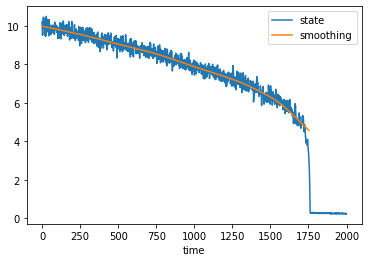

In [72]:
ts.state[['state','smoothing']].plot();

***Compute EWS*** It's time to compute EWS on the residual data. This is done by applying method functions to the TimeSeries attribute. Below we will compute the variance, lag-1 autocorrelation and skew, though there are other methods that can be found in the documentation [here](https://ewstools.readthedocs.io/en/latest/). Define a rolling window length, which can be given as a proporiton of the pre-bifurcation data, or an absolute number of data points.

In [73]:
ts.compute_variance(rolling_window=0.5)
ts.compute_auto(rolling_window=0.5, lag=1)
ts.compute_skew(rolling_window=0.5)

This will fill up the *ews* DataFrame in the TimeSeries object.

In [74]:
ts.ews.dropna().head()

,variance,lag1ac,skew
time,,,
875,0.045833,0.356247,0.051187
876,0.045807,0.357631,0.051281
877,0.045796,0.357016,0.050285
878,0.045883,0.354535,0.047749
879,0.045699,0.353411,0.050706


**Visualise the EWS:** We can create a simple plot of the state and EWS data in matplotlib.

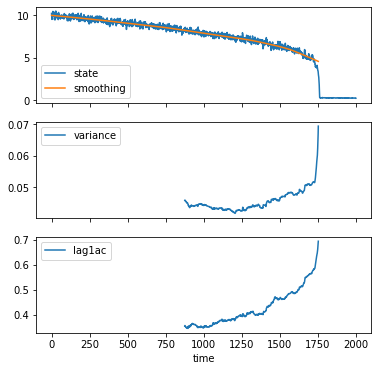

In [75]:
fig1, axes = plt.subplots(nrows=3, ncols=1, figsize=(6,6), sharex=True)
ts.state[['state','smoothing']].plot(ax=axes[0])
ts.ews['variance'].plot(ax=axes[1],legend=True)
ts.ews['lag1ac'].plot(ax=axes[2],legend=True);

**Compute Kendall tau values**

In [76]:
ktau = ts.compute_ktau()

In [77]:
ktau

{'variance': -1.0, 'lag1ac': 0.33333333333333337, 'skew': -0.33333333333333337}

## Visualise EWS

We can visualise the EWS by constructing some plots using the Seaborn package.

**Early warning signals**

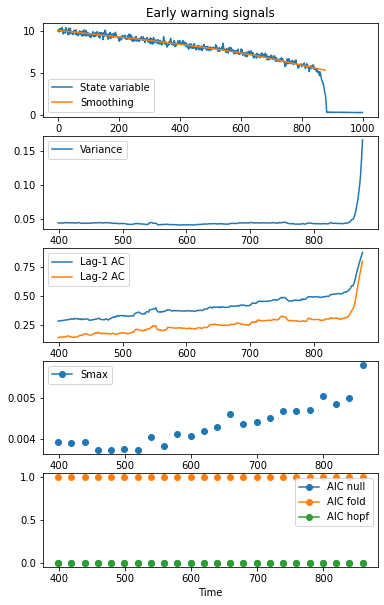

In [13]:
## Plot of trajectory, smoothing and EWS of var (x or y)
fig1, axes = plt.subplots(nrows=5, ncols=1, figsize=(6,10))
df_ews[['State variable','Smoothing']].plot(ax=axes[0],
          title='Early warning signals')
df_ews['Variance'].plot(ax=axes[1],legend=True)
df_ews[['Lag-1 AC','Lag-2 AC']].plot(ax=axes[2],legend=True)
df_ews['Smax'].plot(ax=axes[3],legend=True, marker='o')
df_ews[['AIC null','AIC fold','AIC hopf']].plot(ax=axes[4],legend=True, marker='o');